# CS5304 Final Project
## Baseline Model
### teammember: Shang Zhou - sz536, Zongcheng Yang - zy338

## Initialization

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.misc import imread
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

directory

In [4]:
ls data/train/

ALB/   BET/   DOL/   LAG/   NoF/   OTHER/ SHARK/ YFT/


train image number

In [5]:
train_dir = 'data/train/'
print('{:<12}{:<12}'.format("Category", "N"))
for category in os.listdir(train_dir):
    if category == '.DS_Store':
        continue
    print('{:<12}{:<12}'.format(category, sum(1 for file in os.listdir(train_dir + category))))

Category    N           
NoF         465         
OTHER       299         
ALB         1719        
DOL         117         
BET         200         
LAG         67          
YFT         734         
SHARK       176         


test image number

In [6]:
print('{:<12}{:<12}'.format("Test", "N"))
print('{:<12}{:<12}'.format('test_stg1', sum(1 for file in os.listdir('data/test_stg1'))))
print('{:<12}{:<12}'.format('test_stg2', sum(1 for file in os.listdir('data/test_stg2'))))

Test        N           
test_stg1   1000        
test_stg2   12153       


train image size

In [7]:
different_file_sizes = {}
for category in os.listdir(train_dir):
    if category == '.DS_Store':
        continue
    for img in os.listdir(train_dir + category):
        im_array = imread(train_dir + category + "/" + img)
        size = "_".join(map(str,list(im_array.shape)))
        different_file_sizes[size] = different_file_sizes.get(size,0) + 1

/Users/zww036/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


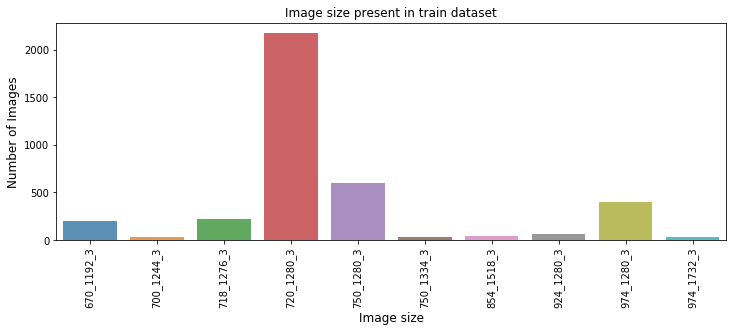

In [8]:
plt.figure(figsize=(12,4))
sns.barplot(list(different_file_sizes.keys()), list(different_file_sizes.values()), alpha=0.8)
plt.xlabel('Image size', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title("Image size present in train dataset")
plt.xticks(rotation='vertical')
plt.show()

## Baseline Model

In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# imports needed for CNN
import csv
import cv2
import os, glob
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import time
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

Using TensorFlow backend.


#### Preprocess

In [21]:
def load_data(data_dir):
    """
    From: https://medium.com/@waleedka/traffic-sign-recognition-with-tensorflow-629dffc391a6#.v471kaepx
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir)
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []

    category = 0
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f)
                      for f in os.listdir(label_dir)
                      if f.endswith(".jpg")]
        
        # adding an early stop for sake of speed
        stop = 0
        for f in file_names:
            img = cv2.imread(f)
            imresize = cv2.resize(img, (200, 125))
            '''
            print(f)
            plt.subplot(121)
            plt.imshow(img)
            plt.subplot(122)
            plt.imshow(imresize)
            plt.show()
            '''
            images.append(imresize)
            labels.append(category)
            
            '''
            # remove this to use full data set
            if stop > 3:
                break
            stop += 1
            # end early stop
            '''
        
        print(category)
        category += 1    
    return images, labels

In [22]:
train_dir = "data/train"
images, labels = load_data(train_dir)

0
1
2
3
4
5
6
7


In [23]:
# confirm that we have the data
#print(images[0:10])
#print(labels)

In [24]:
def cross_validate(Xs, ys):
    X_train, X_test, y_train, y_test = train_test_split(
            Xs, ys, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test

In [25]:
X_train, X_test, y_train, y_test = cross_validate(images, labels)

In [26]:
# confirm we got our data
print(y_test[0:10])

[1, 7, 3, 2, 2, 7, 2, 3, 2, 2]


In [27]:
# normalize inputs from 0-255 and 0.0-1.0
X_train = np.array(X_train).astype('float32')
X_test = np.array(X_test).astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

# one hot encode outputs
y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
print("Data normalized and hot encoded.")

Data normalized and hot encoded.


In [28]:
def createCNNModel(num_classes):
    """ Adapted from: # http://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/
# """
    # Create the model
    model = Sequential()
    model.add(Convolution2D(32, 3, 3, input_shape=(125, 200, 3), border_mode='same', activation='relu', W_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same', W_constraint=maxnorm(3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', W_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    epochs = 8  # >>> should be 25+
    lrate = 0.01
    decay = lrate/epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    print(model.summary())
    return model, epochs

# create our CNN model
model, epochs = createCNNModel(num_classes)
print("CNN Model created.")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 125, 200, 32)      896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 125, 200, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 200, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 100, 32)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 198400)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               101581312 
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

/Users/zww036/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(125, 200,..., activation="relu", padding="same", kernel_constraint=<keras.con...)`
  
/Users/zww036/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same", kernel_constraint=<keras.con...)`
  
/Users/zww036/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_constraint=<keras.con...)`
  # This is added back by InteractiveShellApp.init_path()


In [29]:
# fit and run our model
seed = 5304
np.random.seed(seed)
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=epochs, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

print("done")

/Users/zww036/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 3021 samples, validate on 756 samples
Epoch 1/8
3021/3021 [==============================] - 185s 61ms/step - loss: 1.6926 - acc: 0.4373 - val_loss: 1.4140 - val_acc: 0.5093
Epoch 2/8
3021/3021 [==============================] - 182s 60ms/step - loss: 1.2000 - acc: 0.5981 - val_loss: 1.0518 - val_acc: 0.7050
Epoch 3/8
3021/3021 [==============================] - 183s 61ms/step - loss: 0.8360 - acc: 0.7193 - val_loss: 0.6724 - val_acc: 0.8108
Epoch 4/8
3021/3021 [==============================] - 179s 59ms/step - loss: 0.5707 - acc: 0.8126 - val_loss: 0.5402 - val_acc: 0.8466
Epoch 5/8
3021/3021 [==============================] - 182s 60ms/step - loss: 0.4712 - acc: 0.8500 - val_loss: 0.4402 - val_acc: 0.8836
Epoch 6/8
3021/3021 [==============================] - 181s 60ms/step - loss: 0.3716 - acc: 0.8828 - val_loss: 0.3427 - val_acc: 0.8929
Epoch 7/8
3021/3021 [==============================] - 176s 58ms/step - loss: 0.2830 - acc: 0.9163 - val_loss: 0.3134 - val_acc: 0.9114
E

In [170]:
def validation(stage):
    prediction_output_list = []  # list of lists, containing logistic regression for each file
    fnames = [f for f in listdir("data/test_stg%s/" %stage) if isfile(join("data/test_stg%s/" %stage, f))]

    # early stoppage...
    # only do 10
    i = 0
    for f in fnames:
        file_name = ("data/test_stg%s/" %stage) + f
        img = cv2.imread(file_name)  
        imresize = cv2.resize(img, (200, 125))  # resize so we're always comparing same-sized images
        imlist = np.array([imresize])
        #print("---Evaluating File at: " + file_name)
        #print("Neural Net Prediction:")
        cnn_prediction = model.predict_proba(imlist)
        #print(cnn_prediction)

        # format list for csv output
        csv_output_list = []
        if stage == "1":
            csv_output_list.append(f)
        else:
            csv_output_list.append('test_stg2/' + f)
        for elem in cnn_prediction:
            for value in elem:
                csv_output_list.append(value)

        # append filename to make sure we have right format to write to csv
        #print("CSV Output List Formatted:")
        #print(csv_output_list)
        # and append this file to the output_list (of lists)
        prediction_output_list.append(csv_output_list)
        
        i += 1
        if i % 100 == 0:
            print(i//100)
    
    return prediction_output_list
    
'''
############## STOP EARLY TO SAVE TIME #################
if i > 10:
    break
i += 1
#####  REMOVE TO RUN AGAINST FULL TEST SET ########
'''

'\n############## STOP EARLY TO SAVE TIME #################\nif i > 10:\n    break\ni += 1\n#####  REMOVE TO RUN AGAINST FULL TEST SET ########\n'

In [171]:
list1 = validation("1")
list2 = validation("2")
prediction_output_list = list1 + list2

1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121


In [172]:
# Write to csv
#  Commented out for Kaggle, but you can use this to write to a CSV on your own computer.
try:
    with open("cnn_predictions.csv", "w") as f:
        writer = csv.writer(f)
        headers = ['image', 'ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
        writer.writerow(headers)
        writer.writerows(prediction_output_list)
finally:
    f.close()

print("done")

done


In [149]:
import pandas as pd
df = pd.read_csv('data/sample_submission_stg2.csv')
df.shape

(13153, 9)

In [150]:
df.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00005.jpg,0.455003,0.052938,0.030969,0.017734,0.123081,0.079142,0.046585,0.194283
1,img_00007.jpg,0.455003,0.052938,0.030969,0.017734,0.123081,0.079142,0.046585,0.194283
2,img_00009.jpg,0.455003,0.052938,0.030969,0.017734,0.123081,0.079142,0.046585,0.194283
3,img_00018.jpg,0.455003,0.052938,0.030969,0.017734,0.123081,0.079142,0.046585,0.194283
4,img_00027.jpg,0.455003,0.052938,0.030969,0.017734,0.123081,0.079142,0.046585,0.194283
